# Train and fine-tune an OCR model

I will be using this guide here: https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_Seq2SeqTrainer.ipynb

How to build my image dataset: https://huggingface.co/docs/datasets/en/image_dataset

In [29]:
import pandas as pd

df = pd.read_csv("text_in_image.csv")
df

,file_name,text
0,activity_expression.png,activity expression flight operation percentag...


In [17]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

model_name = "microsoft/trocr-small-printed"
processor = TrOCRProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


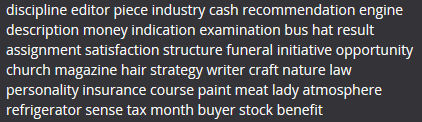

In [27]:
from PIL import Image

image = Image.open("images/discipline_editor.png").convert("RGB")
image

In [19]:
pixel_values = processor(images=image, return_tensors="pt").pixel_values

In [20]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [21]:
generated_text

['POSTED FOR AN OFFER']